### Introduction

In this project, you will be continuing your work with the *Escherichia coli* core model and investigate how the growth phenotype of the model changes when varying one or multiple exchange fluxes (i.e., production envelopes and phenotype phase planes). Additionally, you will be conducting a gene essentiality analysis on the model where the deletion of a gene can be simulated by simply constraining the lower and upper flux bounds of its associated reactions to 0. Gene deletion analysis is a common application of genome-scale metabolic models and allow us to assess the effects of a gene deletion on the metabolic phenotype of an organism before initiating expensive and time-consuming experiments in the lab. I recommend taking a look at the cobrapy documentation before starting with the project, particularly the section on deletion analysis found [here](https://cobrapy.readthedocs.io/en/latest/deletions.html).


In [122]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

from cobra.io import read_sbml_model 
from cobra.flux_analysis import (production_envelope, single_gene_deletion, double_gene_deletion)
from phpp import PhenotypePhasePlane, PhPP

In [123]:
ecoli_model = read_sbml_model("ecoli_core_model.xml")

def foo(model, o2_lower_bound, o2_upper_bound, 
        carbon_source, carbon_source_lower_bound, 
        carbon_source_upper_bound, no_glucose=False):
    local_model = model.copy()
    local_model.reactions.get_by_id("EX_o2_e").lower_bound = o2_lower_bound
    local_model.reactions.get_by_id("EX_o2_e").upper_bound = o2_upper_bound
    local_model \
        .reactions.get_by_id(carbon_source).lower_bound = carbon_source_lower_bound
    local_model \
        .reactions.get_by_id(carbon_source).upper_bound = carbon_source_upper_bound
    # I think that glucose is available by default. Change that:
    if (no_glucose):
        local_model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0

    local_model.optimize()

    prod_env = production_envelope(local_model, [carbon_source], 
                                   carbon_sources=carbon_source, points=40)
    prod_env[str(carbon_source)+".transformed"] =  -1*prod_env[carbon_source]

    name_dict = {"EX_glc__D_e" : "glucose",
                 "EX_succ_e" : "succinate"}

    chart = plt.plot(prod_env[(str(carbon_source)+".transformed")], prod_env["carbon_yield_maximum"], )
    return chart




### 1.1 Phenotype phase plane analysis

(i) Using the cobrapy function `production_envelope` (see [documentation](https://cobrapy.readthedocs.io/en/latest/phenotype_phase_plane.html)), calculate the growth rate as a function of glucose uptake flux when oxygen is unlimited for the *E. coli* core model. Plot growth vs. glucose uptake flux from 0 to -25 mmol gDW<sup>-1</sup> h<sup>-1</sup> using 40 plot points.

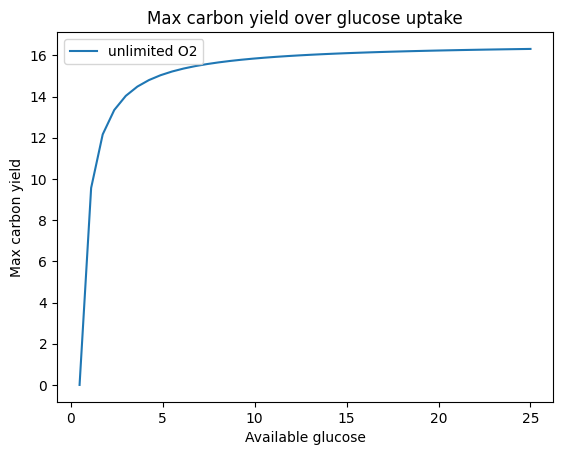

In [124]:
fig, ax = plt.subplots()
high_O2 = foo(ecoli_model, -1000, 0, "EX_glc__D_e", -25, 0)
ax.set_title(f"Max carbon yield over glucose uptake")
ax.set_xlabel(f"Available glucose")
ax.set_ylabel("Max carbon yield")
plt.legend(
    ["unlimited O2", 
    "max 10 mmol gDW\u207B\u00B9h\u207B\u00B9 O2"])
plt.show()

(ii) Same as in (i), but now limit the oxygen uptake flux to -10 mmol gDW<sup>-1</sup> h<sup>-1</sup> . Compare and explain the differences with the results from (i).

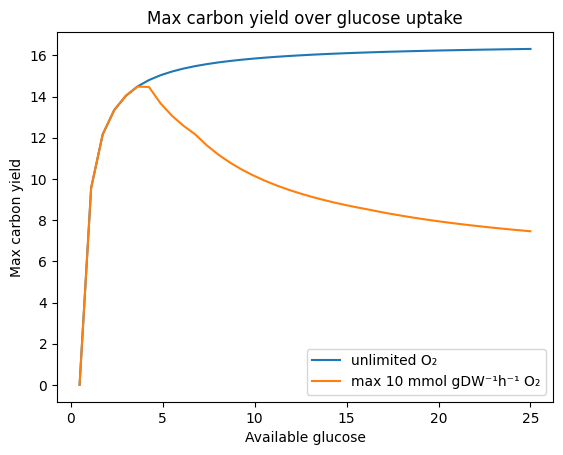

In [125]:
fig, ax = plt.subplots()
high_O2_glu = foo(ecoli_model, -1000, 0, "EX_glc__D_e", -25, 0)
Low_O2_glu = foo(ecoli_model, -10, 0, "EX_glc__D_e", -25, 0)
ax.set_title(f"Max carbon yield over glucose uptake")
ax.set_xlabel(f"Available glucose")
ax.set_ylabel("Max carbon yield")
plt.legend(["unlimited O\u2082", "max 10 mmol gDW\u207B\u00B9h\u207B\u00B9 O\u2082"])
plt.show()

(iii) Same as in (i) and (ii), but with succinate as the only carbon source. Compare and explain the differences with the results from (i) and (ii). Use the calculated growth rates from Table 1 in Project 3 to argue for your results.

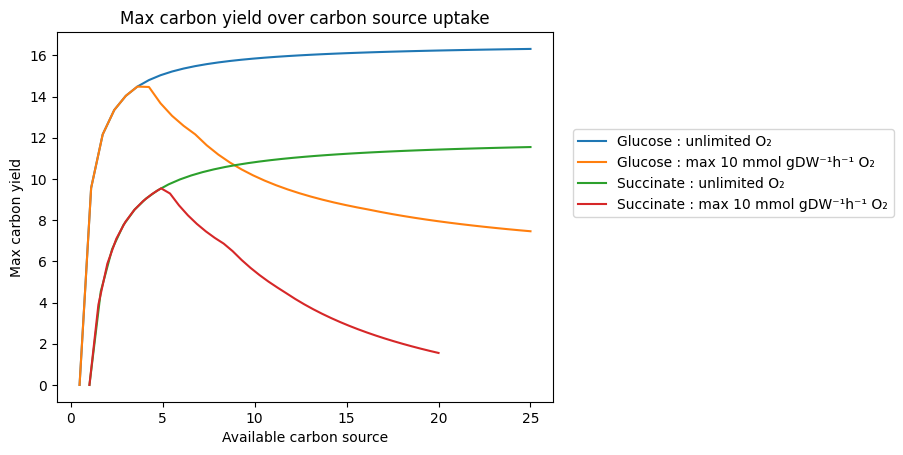

In [126]:
fig, ax = plt.subplots()
high_O2_glu = foo(ecoli_model, -1000, 0, "EX_glc__D_e", -25, 0)
Low_O2_glu = foo(ecoli_model, -10, 0, "EX_glc__D_e", -25, 0)
high_O2_suc = foo(ecoli_model, -1000, 0, "EX_succ_e", -25, 0, True)
Low_O2_suc = foo(ecoli_model, -10, 0, "EX_succ_e", -25, 0, True)
ax.set_title(f"Max carbon yield over carbon source uptake")
ax.set_xlabel(f"Available carbon source")
ax.set_ylabel("Max carbon yield")
plt.legend(
    ["Glucose : unlimited O\u2082", 
     "Glucose : max 10 mmol gDW\u207B\u00B9h\u207B\u00B9 O\u2082", 
     "Succinate : unlimited O\u2082", 
     "Succinate : max 10 mmol gDW\u207B\u00B9h\u207B\u00B9 O\u2082"], 
     loc=(1.04,0.5))
plt.show()



Commonly, we classify the linear segments of the production envelopes by their *shadow prices*, which are defined as

$
\begin{align}
 \pi_i = -\frac{\partial Z}{\partial b_i}.
\end{align}
$

The shadow prices $\pi_i$ defines the sensitivity of the objective function $Z$ to changes in the availability of a given metabolite $i$. $b_i$ defines the violation of the mass balance constraint of metabolite $i$ and is equivalent to an uptake reaction. In other words, it quantitatively describes how the objective function value would change if we could import more of an exchangeable metabolite. A negative $\pi_i$ indicates that increasing the availability of a metabolite $i$ will increase the optimal objective value, while a positive $\pi_i$ indicates that the optimal objective value will decrease.

While production envelopes plotted above are interesting in their own right, it is often more informative to investigate the growth phenotype when adjusting two exchange fluxes simultaneously. This is called phenotype phase plane analysis (PhPP). Rather than forming linear segments, PhPP results in the formation of two-dimensional planes which are defined by their metabolic phenotype and shadow prices of the two variable exchange metabolites.

(iv) Start by plotting a PhPP and associated shadow prices for glucose and oxygen using the *E. coli* core model and the `PhPP` function and associated plotting functions found on Blackboard (`phpp.py`). Use a `flux_range` evenly distributed between 0 and -20 with 50 data points. Note that you will be needing the Python package `palettable`.

In [127]:
flux_range = np.linspace(0, -20, 50)
plane = PhPP(
    model=ecoli_model, 
    rxn_x="EX_glc__D_e", 
    rxn_y="EX_o2_e", 
    rxn_x_range=flux_range, 
    rxn_y_range=flux_range)

C:\Users\Legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Legion\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
 

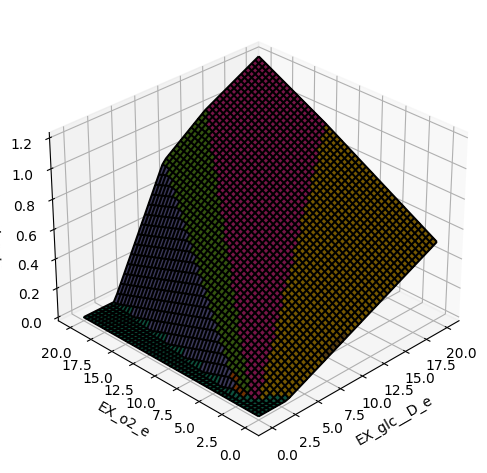

In [128]:
# Plot the phenotypic phase planes:
plane.plot_PhPP()

We can observe that the shadow prices $\pi_i$ are constant in each of the phase planes. Consequently, we can determine the properties of the different phases by calculating

$
\begin{align}
 \alpha = -\frac{\pi_x}{\pi_y},
\end{align}
$

the ratio between the shadow prices associated with the two exchange fluxes $x$ and $y$ (here, glucose and oxygen). We can then define four types of phases in PhPP:
1. If $\alpha < 0$, the objective function is limited by both exchange fluxes (*dual substrate limitation*).
2. If $\alpha > 0$, the region is called a *futile phase*: one of the exchange substrates will have a positive shadow price. Characterized by wasteful metabolic operations (substrate consumed does not improve $Z$).
3. If either $\pi_x = 0$ or $\pi_y = 0$, the region is described by *single substrate limitation*.
4. *Infeasible phases* due to a combination of stoichiometric limitations and/or substrate availability (no growth).

(v) How many unique phases does this PhPP have? Classify these according to the four types defined above.

In [129]:
def alpha(sp_x, sp_y):
    if sp_x == 0 or sp_y == 0:
        return 0
    else:
        return -(sp_x/sp_y)

def handle_alpha(alpha):
    if alpha < 0:
        return "Dual substrate limitation"
    elif alpha > 0:
        return "Futile phase"
    elif alpha == 0:
        return "Single substrate limitation"
    else:
        return "Infeasible phases"  # This will never run \
        # according to the criteria in the task description!

# Identify the segments:
plane.segment()

# Print output:
print(f"Number of unique phases {len(plane.phases)}. The phases are:")
counter = 0
for phase in plane.phases:
    counter += 1
    print(f"# Phase {counter}:")
    print("x={x: >7.4f}, y={y: >7.4f}, \tshadow price 1: {sp1: >7.4f}, shadow price 2: {sp2: >7.4f}".format(x=phase[0][0], y=phase[0][1], sp1=phase[1], sp2=phase[2]))
    print(f"The phase is described as: {handle_alpha(alpha=alpha(phase[1], phase[2]))}\n")

Number of unique phases 7. The phases are:
# Phase 1:
x= 0.0000, y= 0.0000, 	shadow price 1:  0.0000, shadow price 2:  0.0000
The phase is described as: Single substrate limitation

# Phase 2:
x=-0.8163, y=-2.4490, 	shadow price 1: -0.0498, shadow price 2: -0.0223
The phase is described as: Dual substrate limitation

# Phase 3:
x=-0.8163, y=-3.6735, 	shadow price 1: -0.1373, shadow price 2:  0.0229
The phase is described as: Futile phase

# Phase 4:
x=-1.2245, y=-1.6327, 	shadow price 1: -0.0325, shadow price 2: -0.0325
The phase is described as: Dual substrate limitation

# Phase 5:
x=-1.2245, y=-2.4490, 	shadow price 1: -0.0459, shadow price 2: -0.0230
The phase is described as: Dual substrate limitation

# Phase 6:
x=-1.6327, y=-1.2245, 	shadow price 1: -0.0305, shadow price 2: -0.0360
The phase is described as: Dual substrate limitation

# Phase 7:
x=-7.3469, y= 0.0000, 	shadow price 1: -0.0305, shadow price 2: -0.0581
The phase is described as: Dual substrate limitation



**From the code output I guess that Phase 1 can actually be described as a Dual substrate limitation, given that both substrate levels are 0.**

(vi) Considering the reasonable assumption of growth optimality, where do you think *E. coli* strains will be located on this PhPP in vivo?

### 1.2 Gene deletion analysis

(i) Conduct a single gene deletion study for all the genes in the *E. coli* core model. Use the default defined nutrient environment (i.e. aerobic glucose).

(a) By making a scatter plot of the relative growth rates (mutant growth / wild type growth) for all gene deletions, define what you consider to be an essential gene.

In [130]:
deletion_results = single_gene_deletion(ecoli_model)

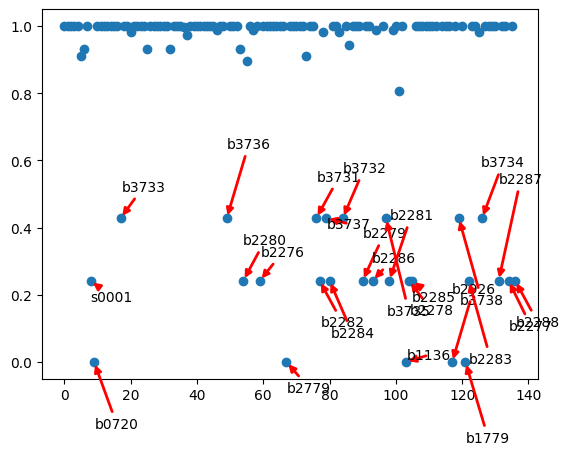

In [131]:
wt_growth = ecoli_model.optimize().objective_value
deletion_results["relative_growth_rate"] = deletion_results.growth/wt_growth

fig, ax = plt.subplots()
ax.scatter(list(range(deletion_results.shape[0])), deletion_results.relative_growth_rate)
# Add 
arrowprops=dict(arrowstyle='-|>', color="red", linewidth=2)
for i, txt in enumerate(deletion_results.ids):
    txt = str(txt)[2:-2]
    if deletion_results.relative_growth_rate[i] < 0.5:
        x = list(range(deletion_results.shape[0]))[i]
        y = deletion_results.relative_growth_rate[i]
        ax.annotate(
            txt, 
            xy=(x,y),
            xytext=(
                x+random.uniform(-0.3, 0.3), 
                y+random.uniform(-0.3, 0.3)),
            arrowprops=arrowprops
            )
plt.show()

(b) Identify the name and function of all the essential genes you found. While checking which reactions these genes are associateed with in the model is useful, it can also be an idea to check biochemical databases for informations such as [EcoCyc](https://ecocyc.org/).

In [156]:
# Define an essentiality threshold
essentiality_threshold = 10**(-10)

for row in range(deletion_results.shape[0]):
    if deletion_results.relative_growth_rate[row] < essentiality_threshold:
        gene = str(deletion_results.ids[row])[2:-2]
        display(getattr(ecoli_model.genes, gene))
        print("Relative growth rate of: {gr:.4f}"\
            .format(
                gr=deletion_results.relative_growth_rate[row]
                ))
        print()

# NB! Used later! Store a df with only essential genes:
df_essential_KO = deletion_results[deletion_results.relative_growth_rate < essentiality_threshold]

Gene identifier,b0720
Name,
Memory address,0x1e9e1acbc10
Functional,True
In 1 reaction(s),CS


Relative growth rate of: -0.0000



Gene identifier,b2779
Name,
Memory address,0x1e9e27287f0
Functional,True
In 1 reaction(s),ENO


Relative growth rate of: 0.0000



Gene identifier,b1136
Name,
Memory address,0x1e9e2729d20
Functional,True
In 1 reaction(s),ICDHyr


Relative growth rate of: -0.0000



Gene identifier,b2926
Name,
Memory address,0x1e9e2728520
Functional,True
In 1 reaction(s),PGK


Relative growth rate of: 0.0000



Gene identifier,b1779
Name,
Memory address,0x1e9e2728d60
Functional,True
In 1 reaction(s),GAPD


Relative growth rate of: -0.0000



b0720 - CS:
    Enzyme:     citrate synthase
    Gene:       gltA
    Function:   Synthesize citrate (metabolite in e.g. TCA cycle) 
    Pathways:   glyoxylate cycle
                TCA cycle I (prokaryotic)
                Mixed acid fermentation

b2779 - ENO
    Enzyme:     enolase  
    Gene:       eno
    Function:   Catalyze the conversion (both direction) of 
                metabolite in glycolysis and/or gluconeogenesis
    Pathways:   gluconeogenesis I
                glycolysis II (from fructose 6-phosphate)
                glycolysis I (from glucose 6-phosphate)

b1136 - ICDHyr
    Enzyme:     isocitrate dehydrogenase
    Gene:       icd
    Function:   Catalyze reaction in TCA cycle
    Pathways:   TCA cycle I (prokaryotic)
                Mixed acid fermentation

b2926 - PGK
    Enzyme:     phosphoglycerate kinase  
    Gene:       pgk
    Function:   Catalyze reaction in glycolysis and gluconeogenesis
    Pathways:   gluconeogenesis I
                glycolysis II (from fructose 6-phosphate)
                glycolysis I (from glucose 6-phosphate) 

b1779 - GAPD
    Enzyme:     glyceraldehyde-3-phosphate dehydrogenase
    Gene:       gapA
    Function:   Catalyze reaction in glycolysis and gluconeogenesis
    Pathways:   gluconeogenesis I
                glycolysis II (from fructose 6-phosphate)
                glycolysis I (from glucose 6-phosphate)

(c) Give plausible explanations for why they are essential.

**So, all the essential genes seems to encode enzymes that are either part of the glycolysis/gluconeogenesis, or the TCA cycle. It would make sense that these are essential in the default ecoli core model, as the sole energy source is glucose. I came across something about ecoli being able to survive on some metabolite if one of the enzyme was inhibited, probably by using other (parts) of pathways. However, that is of course only relevant if the other energy sources are available.** 

(ii) Change the single carbon source from glucose to acetate and redo the analysis in (a) (no need to go into detail on the function of each gene, comment on the general trend). Also, identify the essential genes that are common to both nutrient environments, and those that are specific to acetate. Explain why this is so.

In [133]:
ecoli_model_acetate = ecoli_model.copy()
ecoli_model_acetate.reactions.get_by_id("EX_ac_e").lower_bound = ecoli_model_acetate.reactions.get_by_id("EX_glc__D_e").lower_bound
ecoli_model_acetate.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
ecoli_model_acetate.optimize()

deletion_results_acetate = single_gene_deletion(ecoli_model_acetate)

wt_growth_acetate = ecoli_model_acetate.optimize().objective_value
deletion_results_acetate["relative_growth_rate"] = deletion_results_acetate.growth/wt_growth_acetate

for row in range(deletion_results_acetate.shape[0]):
    if deletion_results_acetate.relative_growth_rate[row] < essentiality_threshold: 
        gene = str(deletion_results_acetate.ids[row])[2:-2]
        display(getattr(ecoli_model.genes, gene))
        print("Relative growth rate of: {gr:.4f}"\
            .format(
                gr=deletion_results_acetate.relative_growth_rate[row]
                ))
        print()

Gene identifier,b4015
Name,
Memory address,0x1e9e2728bb0
Functional,True
In 1 reaction(s),ICL


Relative growth rate of: 0.0000



Gene identifier,b4025
Name,
Memory address,0x1e9e2728af0
Functional,True
In 1 reaction(s),PGI


Relative growth rate of: 0.0000



Gene identifier,b2779
Name,
Memory address,0x1e9e27287f0
Functional,True
In 1 reaction(s),ENO


Relative growth rate of: -0.0000



Gene identifier,b2926
Name,
Memory address,0x1e9e2728520
Functional,True
In 1 reaction(s),PGK


Relative growth rate of: 0.0000



Gene identifier,b3919
Name,
Memory address,0x1e9e2729630
Functional,True
In 1 reaction(s),TPI


Relative growth rate of: -0.0000



Gene identifier,b1136
Name,
Memory address,0x1e9e2729d20
Functional,True
In 1 reaction(s),ICDHyr


Relative growth rate of: 0.0000



Gene identifier,b1779
Name,
Memory address,0x1e9e2728d60
Functional,True
In 1 reaction(s),GAPD


Relative growth rate of: 0.0000



**As when glucose was the energy source, the essential genes with acetate as energy source are all linked to pathways of energy-metabolism. The genes that are in common are: ENO, ICDHyr, PGK, and GAPD. This makes sense given that acetate can be converted to acetyl-CoA, which is the metabolite added to "start" the TCA cycle.**

(iii) Conduct a complete double-gene deletion study of the model in the original nutrient environment.


In [134]:
ddeletion_results = double_gene_deletion(ecoli_model)
ddeletion_results["relative_growth_rate"] = ddeletion_results.growth/wt_growth


(a) What is the fraction of essential double-gene knockouts?

In [135]:
total_pair_KO = ddeletion_results.shape[0]
essential_pair_KO = ddeletion_results[ddeletion_results.relative_growth_rate < essentiality_threshold].shape[0]
fraction = essential_pair_KO/total_pair_KO

print("The fraction of essential double-gene knockouts is {frac:.5f}".format(frac=fraction))
print(f"There are {essential_pair_KO} of essential double-gene knockouts in total.")

The fraction of essential double-gene knockouts is 0.06273
There are 593 of essential double-gene knockouts in total.


(b)  Which genes are involved in the largest number of essential double-knockout combinations? Any idea why?

In [151]:
df_essential_pair_KO = ddeletion_results[
    ddeletion_results.relative_growth_rate < essentiality_threshold
    ]
individual_genes = set()
for pair in df_essential_pair_KO.ids:
    individual_genes = individual_genes.union(pair)
individual_genes = list(individual_genes)

dic = {key:0 for key in individual_genes}

occurrences = 0 
for key in dic.keys():
    occurrences = 0 
    
    for pair in df_essential_pair_KO.ids:
        if key in pair:
            occurrences += 1
    
    dic[key] = occurrences

# Sort dictionary by occurrences
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

# Top-10:
for elm in range(10):
    gene = list(dic.keys())[elm]
    print(f"\nThe gene {list(dic.keys())[elm]} are involved in {dic[gene]} of essential double-knockout combinations.")
    display(getattr(ecoli_model.genes, gene))



The gene b0720 are involved in 135 of essential double-knockout combinations.


Gene identifier,b0720
Name,
Memory address,0x1e9e1acbc10
Functional,True
In 1 reaction(s),CS



The gene b1136 are involved in 135 of essential double-knockout combinations.


Gene identifier,b1136
Name,
Memory address,0x1e9e2729d20
Functional,True
In 1 reaction(s),ICDHyr



The gene b2926 are involved in 106 of essential double-knockout combinations.


Gene identifier,b2926
Name,
Memory address,0x1e9e2728520
Functional,True
In 1 reaction(s),PGK



The gene b2779 are involved in 106 of essential double-knockout combinations.


Gene identifier,b2779
Name,
Memory address,0x1e9e27287f0
Functional,True
In 1 reaction(s),ENO



The gene b1779 are involved in 106 of essential double-knockout combinations.


Gene identifier,b1779
Name,
Memory address,0x1e9e2728d60
Functional,True
In 1 reaction(s),GAPD



The gene b3956 are involved in 12 of essential double-knockout combinations.


Gene identifier,b3956
Name,
Memory address,0x1e9e27289d0
Functional,True
In 1 reaction(s),PPC



The gene b1761 are involved in 7 of essential double-knockout combinations.


Gene identifier,b1761
Name,
Memory address,0x1e9e2728eb0
Functional,True
In 1 reaction(s),GLUDy



The gene b0722 are involved in 6 of essential double-knockout combinations.


Gene identifier,b0722
Name,
Memory address,0x1e9e1aca140
Functional,True
In 1 reaction(s),SUCDi



The gene b3213 are involved in 6 of essential double-knockout combinations.


Gene identifier,b3213
Name,
Memory address,0x1e9e2729b70
Functional,True
In 1 reaction(s),GLUSy



The gene b2914 are involved in 6 of essential double-knockout combinations.


Gene identifier,b2914
Name,
Memory address,0x1e9e2728730
Functional,True
In 1 reaction(s),RPI


**So, the first five essential double-knockout combinations that showcase in more than two occurrences are all genes that we have already identified for a single gene knockout.** 

(iv) Same analysis as in (iii), but this time with acetate as the single carbon source.

In [148]:
ddeletion_results_acetate = double_gene_deletion(ecoli_model_acetate)

In [152]:
ddeletion_results_acetate["relative_growth_rate"] = ddeletion_results_acetate.growth/wt_growth_acetate

total_pair_KO = ddeletion_results_acetate.shape[0]
essential_pair_KO = ddeletion_results_acetate[ddeletion_results_acetate.relative_growth_rate < essentiality_threshold].shape[0]
fraction = essential_pair_KO/total_pair_KO

print("The fraction of essential double-gene knockouts is {frac:.5f}".format(frac=fraction))
print(f"There are {essential_pair_KO} of essential double-gene knockouts in total.")

df_essential_pair_KO_acetate = ddeletion_results_acetate[ddeletion_results_acetate.relative_growth_rate < essentiality_threshold]
individual_genes = set()
for pair in df_essential_pair_KO_acetate.ids:
    individual_genes = individual_genes.union(pair)
individual_genes = list(individual_genes)

dic = {key:0 for key in individual_genes}

occurrences = 0 
for key in dic.keys():
    occurrences = 0 
    
    for pair in df_essential_pair_KO_acetate.ids:
        if key in pair:
            occurrences += 1
    
    dic[key] = occurrences

dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

# Top-10:
for elm in range(10):
    gene = list(dic.keys())[elm]
    print(f"\nThe gene {list(dic.keys())[elm]} are involved in {dic[gene]} of essential double-knockout combinations.")
    display(getattr(ecoli_model.genes, gene))

The fraction of essential double-gene knockouts is 0.07966
There are 753 of essential double-gene knockouts in total.

The gene b4025 are involved in 110 of essential double-knockout combinations.


Gene identifier,b4025
Name,
Memory address,0x1e9e2728af0
Functional,True
In 1 reaction(s),PGI



The gene b3919 are involved in 110 of essential double-knockout combinations.


Gene identifier,b3919
Name,
Memory address,0x1e9e2729630
Functional,True
In 1 reaction(s),TPI



The gene b2926 are involved in 110 of essential double-knockout combinations.


Gene identifier,b2926
Name,
Memory address,0x1e9e2728520
Functional,True
In 1 reaction(s),PGK



The gene b2779 are involved in 110 of essential double-knockout combinations.


Gene identifier,b2779
Name,
Memory address,0x1e9e27287f0
Functional,True
In 1 reaction(s),ENO



The gene b1779 are involved in 110 of essential double-knockout combinations.


Gene identifier,b1779
Name,
Memory address,0x1e9e2728d60
Functional,True
In 1 reaction(s),GAPD



The gene b1136 are involved in 109 of essential double-knockout combinations.


Gene identifier,b1136
Name,
Memory address,0x1e9e2729d20
Functional,True
In 1 reaction(s),ICDHyr



The gene b4015 are involved in 104 of essential double-knockout combinations.


Gene identifier,b4015
Name,
Memory address,0x1e9e2728bb0
Functional,True
In 1 reaction(s),ICL



The gene b1761 are involved in 9 of essential double-knockout combinations.


Gene identifier,b1761
Name,
Memory address,0x1e9e2728eb0
Functional,True
In 1 reaction(s),GLUDy



The gene b3403 are involved in 9 of essential double-knockout combinations.


Gene identifier,b3403
Name,
Memory address,0x1e9e2729420
Functional,True
In 1 reaction(s),PPCK



The gene b2987 are involved in 8 of essential double-knockout combinations.


Gene identifier,b2987
Name,
Memory address,0x1e9e2729690
Functional,True
In 1 reaction(s),PIt2r


(v) Use the results from (i) and (iii) to identify only the synthetic lethal gene combinations. How many are there?

In [157]:
df_sdel = deletion_results[deletion_results.relative_growth_rate < essentiality_threshold] 
df_ddel = ddeletion_results[ddeletion_results.relative_growth_rate < essentiality_threshold]

print(df_sdel.shape[0])
print(df_essential_KO.shape[0])
print(df_ddel.shape[0])
print(df_essential_pair_KO.shape[0])

5
5
593
593


In [ ]:
df_essential_KO
df_essential_pair_KO

(vi) Select a partial essential gene from (a) (i.e. a gene which when deleted reduces the relative growth rate of the model, but not below the chosen essentiality threshold). Visualize its optimal flux distribution in Escher and compare it to the wild type flux distribution. Discuss and explain the observed differences in flux phenotypes.